In [ ]:
# From
# https://github.com/patrick-kidger/equinox/blob/main/examples/mnist.ipynb
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html

In [103]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [104]:
#@title Create a dataloader
# From https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
import numpy as np
from jax.tree_util import tree_map
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [105]:
#@title Download the dataset
train_data = datasets.MNIST(
    root="~/data", train=True, download=True, transform=FlattenAndCast())
test_data = datasets.MNIST(
    root="~/data", train=False, download=True, transform=FlattenAndCast())

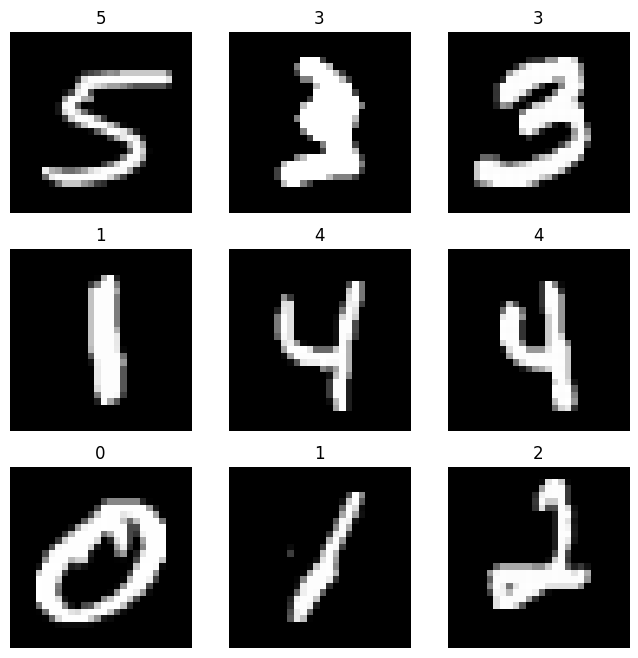

In [108]:
#@title Visualize the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    img = img.reshape(28, 28)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [109]:
train_dataloader = NumpyLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = NumpyLoader(test_data, batch_size=64, shuffle=True)

In [110]:
x, y = next(iter(train_dataloader))
print(x.shape, y.shape)

(64, 784) (64,)


In [156]:
#@title Define the model
import equinox as eqx
import jax

class MLP(eqx.Module):
    layers: list

    def __init__(self, in_size: int, hidden_dims: list[int], key):
        self.layers = []
        prev_dim = in_size
        for dim in hidden_dims:
            key, layer_key = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(
                    in_features=prev_dim,
                    out_features=dim,
                    use_bias=True,
                    key=layer_key
                )
            )
            prev_dim = dim

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            x = jax.nn.relu(x)
        # return log probs (log(softmax(x))
        return x - jax.scipy.special.logsumexp(x)

In [157]:
model = MLP(
    in_size=784,
    hidden_dims=[784, 512, 10],
    key = jax.random.PRNGKey(1235)
)

In [138]:
def one_hot(y, n_classes, dtype=jnp.float32):
    return jnp.array(jnp.arange(n_classes) == y[:, None], dtype=dtype)

In [216]:
@eqx.filter_jit
def accuracy(model, x, y_one_hot):
    targets = jnp.argmax(y_one_hot, axis=1)
    preds = jnp.argmax(jax.vmap(model)(x), axis=1)
    return jnp.mean(preds == targets)

In [217]:
@eqx.filter_jit
def loss(model, x, y_one_hot):
    log_probs = jax.vmap(model)(x)
    return -jnp.mean(jnp.sum(log_probs * y_one_hot, axis=1))

In [218]:
accuracy(model, x, one_hot(y, 10))

Array(0.015625, dtype=float32)

In [219]:
loss(model, x, one_hot(y, 10))

Array(9.541049, dtype=float32)

In [220]:
jax.value_and_grad(loss)(model, x, one_hot(y, 10))

(Array(9.541049, dtype=float32),
 MLP(
   layers=[
     Linear(
       weight=f32[784,784],
       bias=f32[784],
       in_features=784,
       out_features=784,
       use_bias=True
     ),
     Linear(
       weight=f32[512,784],
       bias=f32[512],
       in_features=784,
       out_features=512,
       use_bias=True
     ),
     Linear(
       weight=f32[10,512],
       bias=f32[10],
       in_features=512,
       out_features=10,
       use_bias=True
     )
   ]
 ))

In [256]:
def evaluate(model, testloader, batches=None):
    avg_loss = 0
    avg_acc = 0
    for ix, (x, y) in enumerate(testloader):
        if batches and ix >= batches:
            break
        ix += 1
        y = one_hot(y, 10)
        avg_loss += loss(model, x, y)
        avg_acc += accuracy(model, x, y)
    return avg_loss / ix, avg_acc / ix

In [231]:
import jaxtyping

@eqx.filter_jit
def train_step(
    model: MLP,
    x: jaxtyping.Float[jaxtyping.Array, "batch 784"],
    y: jaxtyping.Int[jaxtyping.Array, "batch 10"],
    opt_state: jaxtyping.PyTree,
    optim,
):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = optim.update(
        grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

In [247]:
def infinite_dataloader():
    while True:
        yield from train_dataloader

In [274]:
import time
import optax
LEARNING_RATE = 3e-4
STEPS = (len(train_data.data) // 64) * 5
PRINT_EVERY = 100
SEED = 5678

EVAL_BATCHES = 128


In [ ]:
def train(
    model: MLP,
    optim,
    test_dataloader,
    opt_state = None
):
    if opt_state is None:
        opt_state = optim.init(eqx.filter(model, eqx.is_array))
    
    start_time = time.time()
    for step, (x, y) in enumerate(infinite_dataloader()):
        if step > STEPS:
            break
        y_one_hot = one_hot(y, 10)
        model, opt_state, train_loss = train_step(
            model,
            x,
            one_hot(y, 10),
            opt_state,
            optim
        )
        if (step % PRINT_EVERY) == 0 or (step == STEPS - 1):
            end_time = time.time()
            test_loss, test_acc = evaluate(model, test_dataloader, EVAL_BATCHES)
            print(
                f"step={step}, time={end_time-start_time:0.2f}s train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}, test_accuracy={test_acc.item()}"
            )
            start_time = end_time
    return model, opt_state

In [291]:
model = MLP(
    in_size=784,
    hidden_dims=[512, 512, 10],
    key = jax.random.PRNGKey(1235)
)

In [292]:
optim = optax.adamw(LEARNING_RATE)
model, _= train(
    model,
    optim,
    train_dataloader,
    test_dataloader
)

step=0, time=0.16s train_loss=9.193140983581543, test_loss=6.930211544036865, test_accuracy=0.2166748046875
step=100, time=0.97s train_loss=1.2780978679656982, test_loss=1.2031207084655762, test_accuracy=0.5367431640625
step=200, time=0.96s train_loss=1.394099473953247, test_loss=1.157686471939087, test_accuracy=0.5615234375
step=300, time=0.95s train_loss=0.98225337266922, test_loss=1.0242713689804077, test_accuracy=0.616455078125
step=400, time=0.97s train_loss=0.7440332770347595, test_loss=0.6099552512168884, test_accuracy=0.793701171875
step=500, time=0.96s train_loss=0.5622569918632507, test_loss=0.4766593277454376, test_accuracy=0.8402099609375
step=600, time=0.96s train_loss=0.3962523341178894, test_loss=0.43783050775527954, test_accuracy=0.8494873046875
step=700, time=0.97s train_loss=0.5509545207023621, test_loss=0.4634822905063629, test_accuracy=0.8411865234375
step=800, time=0.96s train_loss=0.38968390226364136, test_loss=0.4283052682876587, test_accuracy=0.8555908203125
ste

In [294]:
# full test set
evaluate(model, test_dataloader, None)

(Array(0.11711785, dtype=float32), Array(0.9697452, dtype=float32))